# Exploratory Data Analysis

## Tasks:

1. Determine what the user is doing with their wrist during each whole body movement.

2. Determine how many different wrist-motion classes there are.

3. If possible, use features to identify what motion each class is representing.

4. Produce quantitative estimates of the generalization performance of your classifier.

## Import Data and Necessary Libraries

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

In [50]:
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from scipy.linalg import eigh  # for calculating eigenvectors

In [101]:
plt.rcParams["figure.figsize"] = (12,12)

In [3]:
# import data from interim
df = pd.read_csv('./interim/pison_data.csv', index_col=0)
df.head()

,timestamp,channel_0,channel_1,channel_0_hp,channel_1_hp,q_x,q_y,q_z,q_w,g_x,g_y,g_z,a_x,a_y,a_z,body_movement,repetition
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


I want to split the df according to body movement codes (0, 1, 2, 3, 4).

In [5]:
df_0 = df[df['body_movement']==0]

df_1 = df[df['body_movement']==1]

df_2 = df[df['body_movement']==2]

df_3 = df[df['body_movement']==3]

df_4 = df[df['body_movement']==4]
print(df_0.shape, df_1.shape, df_2.shape, df_3.shape, df_4.shape)

(2982, 17) (3006, 17) (2985, 17) (3000, 17) (3008, 17)


The class balance between the body movement codes is good. I want to see if there are distinguishable clusters within the each subset of the total dataframe.

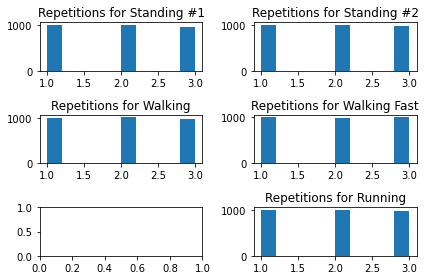

In [6]:
fig, axs = plt.subplots(3, 2)

axs[0,0].hist(df_0['repetition'])
axs[0,0].set_title('Repetitions for Standing #1')

axs[0,1].hist(df_1['repetition'])
axs[0,1].set_title('Repetitions for Standing #2')

axs[1,0].hist(df_2['repetition'])
axs[1,0].set_title('Repetitions for Walking')

axs[1,1].hist(df_3['repetition'])
axs[1,1].set_title('Repetitions for Walking Fast')

axs[2,1].hist(df_4['repetition'])
axs[2,1].set_title('Repetitions for Running')

# _ = plt.hist(df_0['repetition'])

plt.tight_layout()
plt.show()

The repetitions also seem evenly split for each whole body movement.

In [7]:
df_0.describe()

,timestamp,channel_0,channel_1,channel_0_hp,channel_1_hp,q_x,q_y,q_z,q_w,g_x,g_y,g_z,a_x,a_y,a_z,body_movement,repetition
count,2.982000e+03,2.982000e+03,2.982000e+03,2982.000000,2982.000000,2982.000000,2982.000000,2982.000000,2982.000000,2982.000000,2982.000000,2982.000000,2982.000000,2982.000000,2982.000000,2982.0,2982.000000
mean,1.551737e+06,1.252334e+07,1.251100e+07,55.365191,-22.242790,0.269799,0.030627,0.056831,0.439367,9.608796,-2.681105,0.983529,1.615516,-11.144016,1.337795,0.0,1.984239
std,2.926997e+04,4.625126e+05,6.476465e+05,31789.264383,51068.862275,0.308342,0.432441,0.579985,0.334389,106.569236,300.818779,99.780761,5.635892,4.367962,4.913575,0.0,0.815042
min,1.514825e+06,1.040201e+07,1.044034e+07,-422438.000000,-702455.000000,-0.461182,-0.687683,-0.826233,0.000000,-316.637500,-1396.360800,-267.063230,-18.832031,-22.109375,-24.625000,0.0,1.000000
25%,1.517059e+06,1.247265e+07,1.233191e+07,-7547.750000,-9733.000000,0.129547,-0.495285,-0.622681,0.118073,-25.458573,-46.021268,-34.676816,-1.324219,-13.640625,-0.226562,0.0,1.000000
50%,1.552361e+06,1.255198e+07,1.252325e+07,519.000000,721.000000,0.316040,0.106445,0.000366,0.373474,0.111906,1.007152,0.839294,-0.328125,-9.968750,1.027344,0.0,2.000000
75%,1.587323e+06,1.265433e+07,1.264396e+07,8117.250000,11544.250000,0.541138,0.339355,0.715683,0.774658,42.076588,36.719098,39.055130,4.451172,-9.468750,2.906250,0.0,3.000000
max,1.589687e+06,1.419352e+07,1.494834e+07,275168.000000,465110.000000,0.720642,0.685486,0.883179,0.995605,321.449460,1593.818600,242.555860,24.128906,-1.230469,17.507812,0.0,3.000000


### Clustering within Body Movement subsets

(insert description of plot here)

In [8]:
# do RMS(?) on accelerometer data

# try a rolling mean

In [9]:
df_0['a_x']

0       -0.660156
1       -0.660156
2       -0.660156
3       -0.660156
4       -0.660156
           ...   
11028    1.207031
11029    0.441406
11030    0.441406
11031    0.441406
11032    0.441406
Name: a_x, Length: 2982, dtype: float64

In [17]:
# do a rolling standard deviation on the accelerometer data
# window size: 100, 150

a_X = np.array(df_0['a_x'].rolling(150).std())
a_Y = np.array(df_0['a_y'].rolling(150).std())
a_Z = np.array(df_0['a_z'].rolling(150).std())

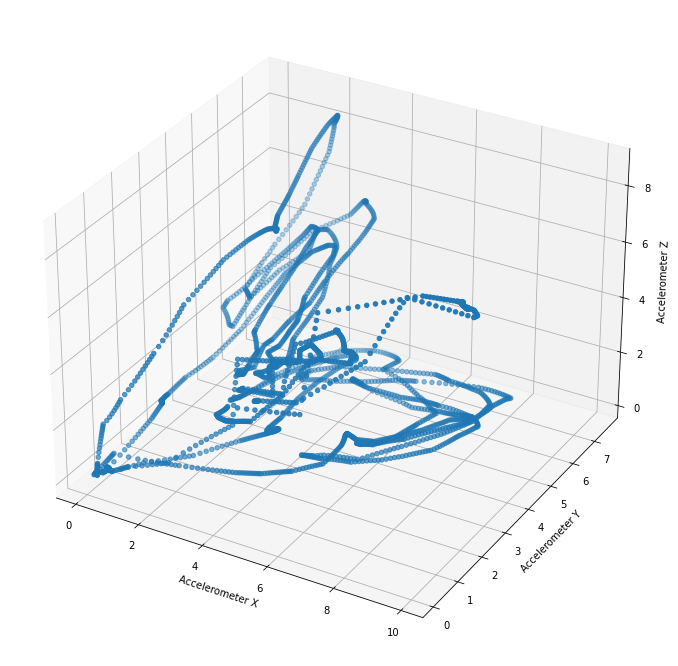

In [23]:
# plot scatter of accelerometer data

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# xs = df_0['a_x']
# ys = df_0['a_y']
# zs = df_0['a_z']

xs = a_X
ys = a_Y
zs = a_Z

ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('Accelerometer X')
ax.set_ylabel('Accelerometer Y')
ax.set_zlabel('Accelerometer Z')

plt.show()

In [20]:
# do a rolling standard deviation on the gyroscope data
# window size: 100, 150

g_X = np.array(df_0['g_x'].rolling(150).std())
g_Y = np.array(df_0['g_y'].rolling(150).std())
g_Z = np.array(df_0['g_z'].rolling(150).std())

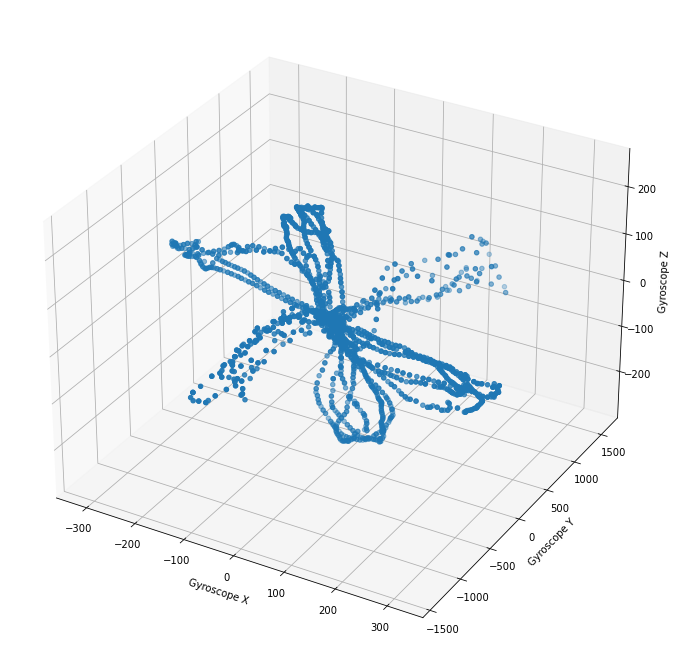

In [24]:
# plot scatter for gyroscope

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = df_0['g_x']
ys = df_0['g_y']
zs = df_0['g_z']

_ = ax.scatter(xs, ys, zs)

ax.set_xlabel('Gyroscope X')
ax.set_ylabel('Gyroscope Y')
ax.set_zlabel('Gyroscope Z')

plt.show()

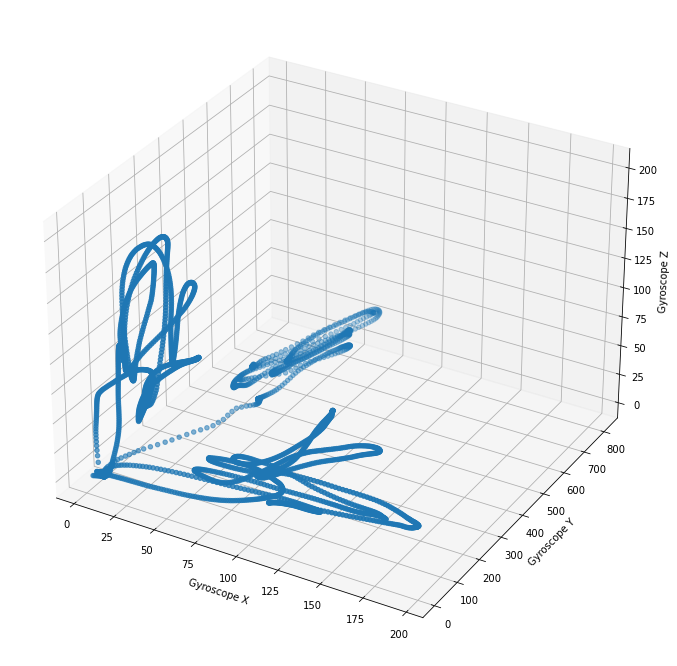

In [25]:
# rolling std on gyroscope

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = g_X
ys = g_Y
zs = g_Z

_ = ax.scatter(xs, ys, zs)

ax.set_xlabel('Gyroscope X')
ax.set_ylabel('Gyroscope Y')
ax.set_zlabel('Gyroscope Z')

plt.show()

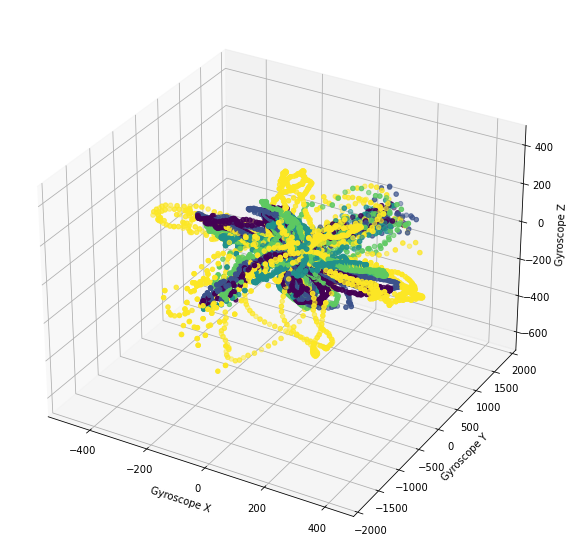

In [81]:
# rolling std on gyroscope

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(projection='3d')

xs = df['g_x']
ys = df['g_y']
zs = df['g_z']

_ = ax.scatter(xs, ys, zs, c=df['body_movement'])

ax.set_xlabel('Gyroscope X')
ax.set_ylabel('Gyroscope Y')
ax.set_zlabel('Gyroscope Z')

plt.show()

In [82]:
# do a rolling standard deviation on the gyroscope data
# window size: 100, 150

g_X = np.array(df['g_x'].rolling(150).std())
g_Y = np.array(df['g_y'].rolling(150).std())
g_Z = np.array(df['g_z'].rolling(150).std())

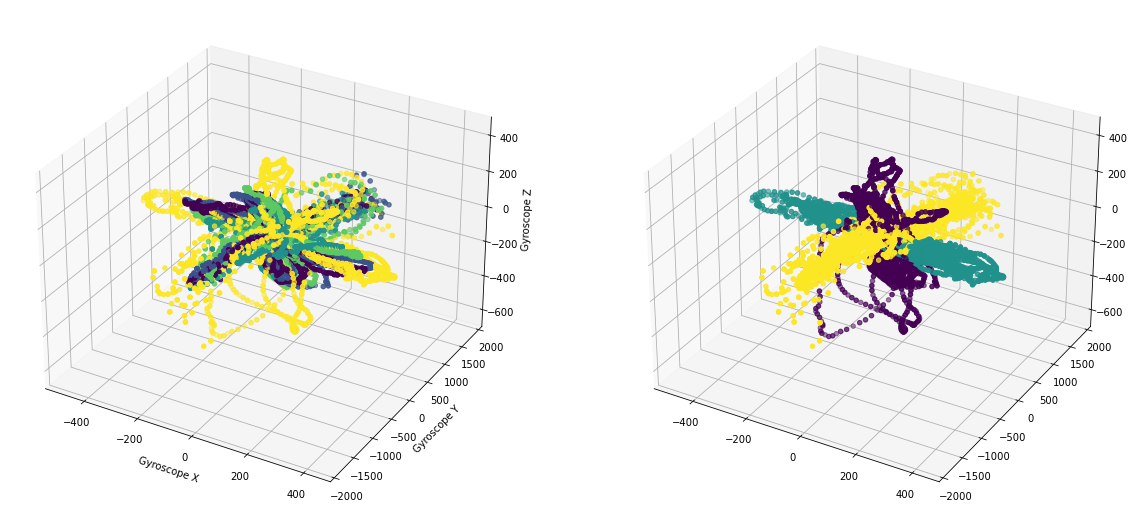

In [103]:
# plot scatter for gyroscope
# fig, axs = plt.subplots(1, 2)
# axs[0] = fig.add_subplot(projection='3d')
# axs[1] = fig.add_subplot(projection='3d')

fig = plt.figure(figsize=[20, 20])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

xs = df['g_x']
ys = df['g_y']
zs = df['g_z']

ax1.scatter(xs, ys, zs, c=df['body_movement'])
ax2.scatter(xs, ys, zs, c=df['repetition'])

ax1.set_xlabel('Gyroscope X')
ax1.set_ylabel('Gyroscope Y')
ax1.set_zlabel('Gyroscope Z')

plt.show()

In [ ]:
# do a rolling standard deviation on the gyroscope data
# window size: 100, 150

g_X = np.array(df['g_x'].rolling(150).std())
g_Y = np.array(df['g_y'].rolling(150).std())
g_Z = np.array(df['g_z'].rolling(150).std())

# plot scatter for gyroscope
# fig, axs = plt.subplots(1, 2)
# axs[0] = fig.add_subplot(projection='3d')
# axs[1] = fig.add_subplot(projection='3d')

fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
ax2 = fig.add_subplot(projection='3d')

xs = df['g_x']
ys = df['g_y']
zs = df['g_z']

_ = ax1.scatter(xs, ys, zs, c=df['body_movement'])
_ = ax2.scatter(xs, ys, zs, c=df['body_movement'])

ax1.set_xlabel('Gyroscope X')
ax1.set_ylabel('Gyroscope Y')
ax1.set_zlabel('Gyroscope Z')

plt.show()

Make a PCA plot. 

Try for one body movement label at a time.

Investigate each cluster further to see if you can identify the movement.

Can also try k-means clustering or hierarchical clustering afterwards.

#### PCA plot

In [134]:
def plot_pca(df, ax):
    # make a copy of the data
    # cut off the last two cols, which hold the 'labels'
    data = df[1:-2]
    
    # standardize the data
    standardized_data = StandardScaler().fit_transform(data)
    
    # co-variance of matrix
    cov_matrix = np.matmul(standardized_data.T, standardized_data)
    
#     # calculate top n eigenvectors for projecting onto an n-dimensional space
#     num_eigvals = []
    
#     while len(num_eigvals) < n_components:
#         for i in range(1, n_components):
#             idx = cov_matrix.shape[0] - i
#             num_eigvals.append(idx)
    
    values, vectors = eigh(cov_matrix, eigvals=(cov_matrix.shape[0]-2, cov_matrix.shape[0]-1))
    vectors = vectors.T
    
    # projecting original data on plane formed by two principals
    new_coord = np.matmul(vectors, standardized_data.T)
    
    # new dataframe for plotting labeled 2D projection
    pca_df = pd.DataFrame(data=new_coord.T, columns=("1st_Principal", "2nd_Principal"))
    
#     plt.sca(ax)
#     scatter = sns.FacetGrid(pca_df, palette='pastel', height=8).map(ax.scatter, '1st_Principal', '2nd_Principal')
#     ax.legend()
    scatter = sns.FacetGrid(pca_df, palette='pastel', height=8).map(ax.scatter, '1st_Principal', '2nd_Principal')
    
    ax.set_xlim(min(pca_df["1st_Principal"])-1, max(pca_df["1st_Principal"])+1)
    ax.set_ylim(min(pca_df["2nd_Principal"])-1, max(pca_df["2nd_Principal"])+1)
    
    ax.set_xlabel('1st Principal')
    ax.set_ylabel('2nd Principal')
#     scatter.add_legend()
    plt.close()

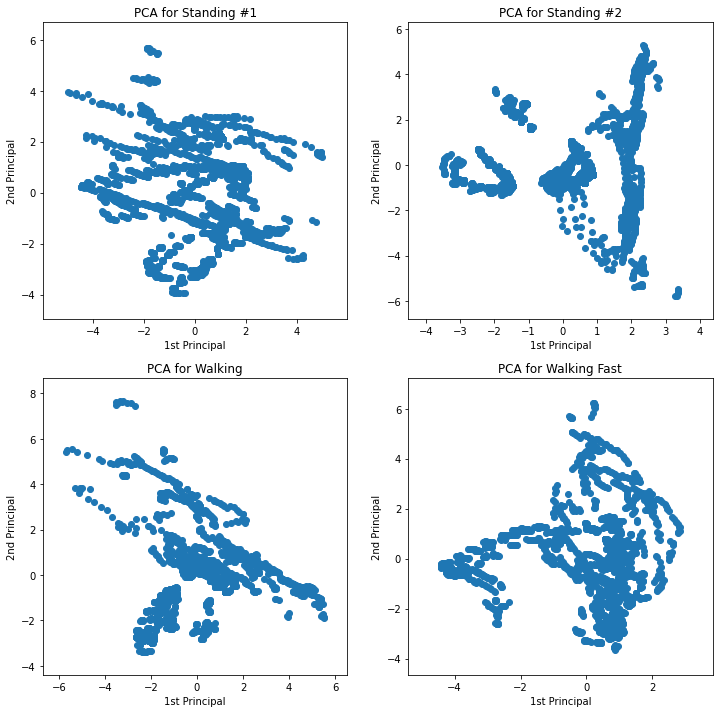

<Figure size 864x864 with 0 Axes>

In [135]:
# PCA plots for each body movement
# color by timestamp to see the movements

fig, axs = plt.subplots(2, 2)
fig = plt.figure()

plot_pca(df_0, axs[0,0])
axs[0,0].set_title('PCA for Standing #1')

plot_pca(df_1, axs[0,1])
axs[0,1].set_title('PCA for Standing #2')

plot_pca(df_2, axs[1,0])
axs[1,0].set_title('PCA for Walking')

plot_pca(df_3, axs[1,1])
axs[1,1].set_title('PCA for Walking Fast')

# ax = fig.add_subplot(3, 2, 5, plot_pca(df_4))
# ax = plot_pca(df_4)
 
plt.show()

In [ ]:
# PCA plots for each body movement
# color by timestamp to see the movements

fig, axs = plt.subplots(2, 2)
fig = plt.figure()

plot_pca(df_0, axs[0,0])
axs[0,0].set_title('PCA for Standing #1')

plot_pca(df_1, axs[0,1])
axs[0,1].set_title('PCA for Standing #2')

plot_pca(df_2, axs[1,0])
axs[1,0].set_title('PCA for Walking')

plot_pca(df_3, axs[1,1])
axs[1,1].set_title('PCA for Walking Fast')

# ax = fig.add_subplot(3, 2, 5, plot_pca(df_4))
# ax = plot_pca(df_4)
 
plt.show()

#### Other Clustering Methods